# Snake using Deep Q-Learning
<hr>
**Author: [Sahil Johari](http://www.sahiljohari.com/)**

TO-DO:
* Change DQNetwork to a minimal level
* Parallelize Convolution process and look for other points for the same
* Compile the project into a presentable format
* Add comments to the code and clean-up

## Business Understanding
_Need to write this after the complete implementation_

## Modeling a Deep Q-Network

In [1]:
'''
Code adapted from https://github.com/danielegrattarola/deep-q-snake/blob/master/DQNetwork.py
'''
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline

class DQN:
    def __init__(self, actions, input_shape, gamma=0.9, load_path='', train_history=False):
        self.model = Sequential()
        self.actions = actions
        self.gamma = gamma
        self.train_history = train_history
        
        filter_idx=-1
        
        num_filter_layers = [32, 64, 64]
        self.model.add(BatchNormalization(axis=1, input_shape=input_shape))
        for num_filters in num_filter_layers:
            filter_idx+=1
            self.model.add(Conv2D(filters=num_filters,
                        input_shape = input_shape,
                        kernel_size=(2,2), 
                        padding='same',
                        activation='relu'))

            self.model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
            if filter_idx != len(num_filter_layers)-1:
                self.model.add(BatchNormalization(axis=1))
                
        self.model.add(Flatten())
        self.model.add(Dropout(0.25))
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dense(self.actions, activation='softmax'))
        
        # Load the network from saved model
        if load_path != '':
            self.load(load_path)
            
        self.model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
        
    def model_summary(self):
        """
        Returns the model summary.
        """
        return self.model.summary()
        
    def train(self, batch):
        """
        Generates inputs and targets from the given batch, trains the model on
        them.
        :param batch: iterable of dictionaries with keys 'source', 'action',
        'dest', 'reward'
        """
        X_train = []
        y_train = []

        # Generate training set and targets
        for datapoint in batch:
            X_train.append(datapoint['source'].astype(np.float64))

            # Get the current Q-values for the next state and select the best
            next_state_pred = self.predict(datapoint['dest'].astype(np.float64)).ravel()
            next_q_value = np.max(next_state_pred)

            # The error must be 0 on all actions except the one taken
            t = list(self.predict(datapoint['source'])[0])
            if datapoint['final']:
                t[datapoint['action']] = datapoint['reward']
            else:
                t[datapoint['action']] = datapoint['reward'] + self.gamma * next_q_value

            y_train.append(t)

        # Prepare inputs and targets
        X_train = np.asarray(X_train).squeeze()
        y_train = np.asarray(y_train).squeeze()

        # Train the model for one epoch
        h = self.model.fit(X_train,
                           y_train,
                           batch_size=32,
                           epochs=1)

        # Log loss and accuracy
        if self.train_history:
            plt.figure(figsize=(15,10))
            plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                                wspace=0.35)
            plt.subplot(1,2,1)
            plt.plot(h.history['acc'][0], label="Training Accuracy")
            plt.xlabel('epochs')
            plt.ylabel('Accuracy %')
            plt.title('DQN Accuracy')
            plt.legend(loc='best')

            plt.subplot(1,2,2)
            plt.plot(h.history['loss'][0], label="Training Loss")
            plt.xlabel('epochs')
            plt.ylabel('DQN Training Loss')
            plt.title('DQN Training Loss')
            plt.legend(loc='best')
            
    def predict(self, state):
        """
        Feeds state into the model, returns predicted Q-values.
        :param state: a numpy.array with same shape as the network's input
        :return: numpy.array with predicted Q-values
        """
        state = state.astype(np.float64)
        return self.model.predict(state, batch_size=1)

    def save(self, filename=None):
        """
        Saves the model weights to disk.
        :param filename: file to which save the weights (must end with ".h5")
        """
        f = ('dqn_game_weights.h5f' if filename is None else filename)
        print('Saving model as %s' % f)
        self.model.save_weights(f, overwrite=True)

    def load(self, path):
        """
        Loads the model's weights from path.
        :param path: h5 file from which to load teh weights
        """
        if self.logger is not None:
            self.logger.log('Loading weights from file...')
        self.model.load_weights(path)

Using TensorFlow backend.


## Defining an Agent

In [2]:
'''
Code taken from https://github.com/danielegrattarola/deep-q-snake/blob/master/DQAgent.py
'''
class DQAgent:
    def __init__(self,
                 actions,
                 batch_size=1024,
                 alpha=0.01,
                 gamma=0.9,
                 epsilon=1,
                 epsilon_rate=0.99,
                 network_input_shape=(2, 84, 84),
                 load_path='',
                 train_history=False):

        # Parameters
        self.actions = actions  # Size of the discreet action space
        self.batch_size = batch_size  # Size of the batch to train the network
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Coefficient for epsilon-greedy exploration
        self.epsilon_rate = epsilon_rate  # Rate at which to make epsilon smaller, as training improves the agent's performance; epsilon = epsilon * rate
        self.min_epsilon = 0.3  # Minimum epsilon value
        # Experience variables
        self.experiences = []
        self.training_count = 0

        # Instantiate the deep Q-network
        self.DQN = DQN(
            self.actions,
            network_input_shape,
            gamma=self.gamma,
            load_path=load_path,
            train_history=train_history
        )

    def get_model_summary(self):
        print(self.DQN.model_summary())
    
    def get_action(self, state, testing=False):
        """
        Poll DCN for Q-values, return greedy action with probability 1-epsilon
        :param state: a state of the MDP with the same size as the DQN input
        :param testing: whether to force a greedy action
        :return: the selected action
        """
        q_values = self.DQN.predict(state)
        if (random.random() < self.epsilon) and not testing:
            return random.randint(0, self.actions - 1)
        else:
            return np.argmax(q_values)

    def add_experience(self, source, action, reward, dest, final):
        """
        Add a tuple (source, action, reward, dest, final) to experiences.
        :param source: a state of the MDP
        :param action: the action associated to the transition
        :param reward: the reward associated to the transition
        :param dest: a state of the MDP
        :param final: whether the destination state is an absorbing state
        """
        self.experiences.append({'source': source,
                                 'action': action,
                                 'reward': reward,
                                 'dest': dest,
                                 'final': final})

    def sample_batch(self):
        """
        Pops self.batch_size random samples from experiences and return them as
        a batch.
        """
        out = [self.experiences.pop(random.randrange(0, len(self.experiences)))
               for _ in range(self.batch_size)]
        return np.asarray(out)

    def must_train(self):
        """"
        Returns true if the number of samples in experiences is greater than the
        batch size.
        """
        return len(self.experiences) >= self.batch_size

    def train(self, update_epsilon=True):
        """
        Samples a batch from experiences, trains the DQN on it, and updates the
        epsilon-greedy coefficient.
        """
        self.training_count += 1
        print ('Training session #', self.training_count, ' - epsilon:', self.epsilon)
        batch = self.sample_batch()
        self.DQN.train(batch)  # Train the DQN
        if update_epsilon:
            self.epsilon = self.epsilon * self.epsilon_rate if self.epsilon > self.min_epsilon else self.min_epsilon  # Decrease the probability of picking a random action to improve exploitation

    def quit(self):
        """
        Saves the DQN to disk.
        """
        self.DQN.save()

## The Game

In [3]:
import argparse
from pygame.locals import *
from PIL import Image, ImageOps
import numpy as np
import pygame
import random
import sys
import os

In [4]:
# CONSTANTS
MAX_EPISODE_LENGTH_FACTOR = 200
MAX_EPISODES_BETWEEN_TRAININGS = 1500
ACTIONS = 4
SCREENSHOT_DIMS = (84, 84)
APPLE_REWARD = 1
DEATH_REWARD = -1
LIFE_REWARD = 0

# GAME CONSTANTS
pygame.init()

display_width = 300
display_height = 300

fps = 30
white = (255,255,255)
black = (0,0,0)
red = (255,0,0)
green = (0,155,0)

# direction = "right"
dirs = ["left", "right", "up", "down"]

icon = pygame.image.load('Assets/appleImg.png')
img = pygame.image.load('Assets/snakehead.png')
appleimg = pygame.image.load('Assets/apple.png')

gameDisplay = pygame.display.set_mode((display_width,display_height))
pygame.display.set_caption('Snake')
pygame.display.set_icon(icon)

block_size = 10
AppleThickness = 20
snake_speed = 5
clock = pygame.time.Clock()

smallfont = pygame.font.SysFont('Trebuchet MS', 14)
medfont = pygame.font.SysFont('Trebuchet MS', 24)
largefont = pygame.font.SysFont('Trebuchet MS', 52)

In [5]:
# ARGUMENTS
args_train = True
args_load = 'dqn_game_weights.h5f'
args_iterations = -1
args_gamma = 0.95

remaining_iters = args_iterations

In [6]:
def init_game():
    global lead_x, lead_y, direction, randAppleX, randAppleY, snakeLength, snakeList, \
    episode_length, episode_reward, gameDisplay, action, state, next_state, must_die
    
    lead_x = display_width/2
    lead_y = display_height/2
    direction = random.choice(dirs)
    snakeList = []
    snakeLength = 1 # will be used for score as (snakeLength-1)
    episode_length = 0
    episode_reward = 0
    must_die = False
    randAppleX, randAppleY = randAppleGen()
    
    # The direction is randomly selected
    action = random.randint(0, ACTIONS - 1)
    # Initialize the states
    state = [screenshot(), screenshot()]
    next_state = [screenshot(), screenshot()]
    
    gameDisplay.fill(white)
    gameDisplay.blit(appleimg, (randAppleX, randAppleY))
    
    snakeHead = []
    snakeHead.append(lead_x)
    snakeHead.append(lead_y)
    snakeList.append(snakeHead)

    snake(block_size, snakeList)
    Score(snakeLength-1)
    pygame.display.update()

In [7]:
def snake(block_size, snakeList):
    if direction == "right":
        head = pygame.transform.rotate(img, 270)
    if direction == "left":
        head = pygame.transform.rotate(img, 90)
    if direction == "up":
        head = pygame.transform.rotate(img, 0)
    if direction == "down":
        head = pygame.transform.rotate(img, 180)

    gameDisplay.blit(head, (snakeList[-1][0], snakeList[-1][1]))
    for XnY in snakeList[:-1]:
        pygame.draw.rect(gameDisplay, green, [XnY[0],XnY[1],block_size,block_size])

def randAppleGen():
    randAppleX = round(random.randrange(0, display_width - AppleThickness) / 10.0) * 10.0
    randAppleY = round(random.randrange(0, display_height - AppleThickness) / 10.0) * 10.0

    return randAppleX, randAppleY

def pause():
    paused = True

    while paused:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    paused = False
                elif event.key == pygame.K_q:
                    pygame.quit()
                    quit()
        gameDisplay.fill(white)
        message_to_screen("Paused", black, -100, 'large')
        message_to_screen("Press 'Space' to continue or 'Q' to quit.", black, 25)

        pygame.display.update()
        clock.tick(5)

def Score(score):
    text = smallfont.render("Score: "+str(score), True, black)
    gameDisplay.blit(text, [0,0])

def text_objects(text, color, size):
    if size == "small":
        textSurface = smallfont.render(text, True, color)
    if size == "medium":
        textSurface = medfont.render(text, True, color)
    if size == "large":
        textSurface = largefont.render(text, True, color)
    return textSurface, textSurface.get_rect()
    
def message_to_screen(msg, color, y_displace=0, size = "small"):
    textSurf, textRect = text_objects(msg, color, size)
    textRect.center = (display_width / 2), (display_height / 2)+y_displace
    gameDisplay.blit(textSurf, textRect)

In [8]:
def screenshot():
    """
    Takes a screenshot of the game, converts it to greyscale, resizes it to
    60x60 and returns it as np.array
    :return:
    """
    global gameDisplay, is_headless
    data = pygame.image.tostring(gameDisplay, 'RGB')  # Take screenshot
    image = Image.frombytes('RGB', (display_width, display_height), data)
    image = image.convert('L')  # Convert to greyscale
    image = image.resize(SCREENSHOT_DIMS)  # Resize
#     image = ImageOps.invert(image) if is_headless else image  # TODO ???
    image = image.convert('1')
    matrix = np.asarray(image.getdata(), dtype=np.float64)
    return matrix.reshape(image.size[0], image.size[1])

In [9]:
def die():
    global logger, remaining_iters, snakeLength, episode_length, episode_reward, \
        must_test, experience_buffer, exp_backup_counter, global_episode_counter
    
    global_episode_counter += 1
    # If agent is stuck, kill the process
    if global_episode_counter > MAX_EPISODES_BETWEEN_TRAININGS:
        print('Shutting process down because something seems to have gone '
                   'wrong during training. Please manually check that '
                   'all is OK and restart the training.')
        DQA.quit()
        sys.exit(0)
        gameExit = True
        
    must_test = False
    
    # Add the episode to the experience buffer
    if snakeLength-1 >= 1 and episode_length >= 10:
        exp_backup_counter += len(experience_buffer)
        print ('Adding episode to experiences - Score: %s; Episode length: %s' \
              % (snakeLength-1, episode_length))
        print ('Got %s samples of %s' % (exp_backup_counter, DQA.batch_size))
        for exp in experience_buffer:
            DQA.add_experience(*exp)
            
    # Train the network (need to replace args.train)
    if DQA.must_train() and args_train:
        exp_backup_counter = 0
        global_episode_counter = 0
        # Quit at the last iteration
        if remaining_iters == 0:
            DQA.quit()
            sys.exit(0)
            gameExit = True

        # Train the DQN
        DQA.train()

        remaining_iters -= 1 if remaining_iters != -1 else 0
        # After training, the next episode will be a test one
        must_test = True

    experience_buffer = []

    # Update graphics and restart episode
    pygame.display.update()
    init_game()

In [10]:
# Agent
DQA = DQAgent(
    ACTIONS,
    gamma=args_gamma,
    load_path=args_load,
    train_history=True
)
DQA.get_model_summary()
experience_buffer = []  # This will store the SARS tuples at each episode

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 2, 84, 84)         8         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 84, 32)         10784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 42, 16)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 42, 16)         8         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 42, 64)         4160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 21, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 21, 32)         8         
__________

In [11]:
# Stats
snakeLength = -1 # equivalent to score = 0
episode_length = 0
episode_reward = 0
episode_nb = 0
exp_backup_counter = 0
global_episode_counter = 0  # Keeps track of how many episodes there were between traning iterations
must_test = False

In [12]:
# Initialize the game variables
lead_x = display_width/2
lead_y = display_height/2
direction = random.choice(dirs)
snakeList = []
snakeLength = 1 # will be used for score as (snakeLength-1)
episode_length = 0
episode_reward = 0
must_die = False
randAppleX, randAppleY = randAppleGen()

# The direction is randomly selected
action = random.randint(0, ACTIONS - 1)
# Initialize the states
state = [screenshot(), screenshot()]
next_state = [screenshot(), screenshot()]

Adding episode to experiences - Score: 1; Episode length: 275
Got 275 samples of 1024
Adding episode to experiences - Score: 1; Episode length: 139
Got 414 samples of 1024
Adding episode to experiences - Score: 1; Episode length: 204
Got 618 samples of 1024
Adding episode to experiences - Score: 1; Episode length: 192
Got 810 samples of 1024
Adding episode to experiences - Score: 1; Episode length: 231
Got 1041 samples of 1024
Training session # 1  - epsilon: 1
Epoch 1/1
1024/1024 [==============================] - 51s 49ms/step - loss: 2.3157 - acc: 0.9443
Adding episode to experiences - Score: 1; Episode length: 364
Got 364 samples of 1024
Adding episode to experiences - Score: 1; Episode length: 250
Got 614 samples of 1024
Adding episode to experiences - Score: 1; Episode length: 401
Got 1015 samples of 1024
Training session # 2  - epsilon: 0.99
Epoch 1/1
1024/1024 [==============================] - 51s 50ms/step - loss: 1.7366 - acc: 0.8730
Adding episode to experiences - Score: 1;

SystemExit: 0

C:\Users\sahil\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


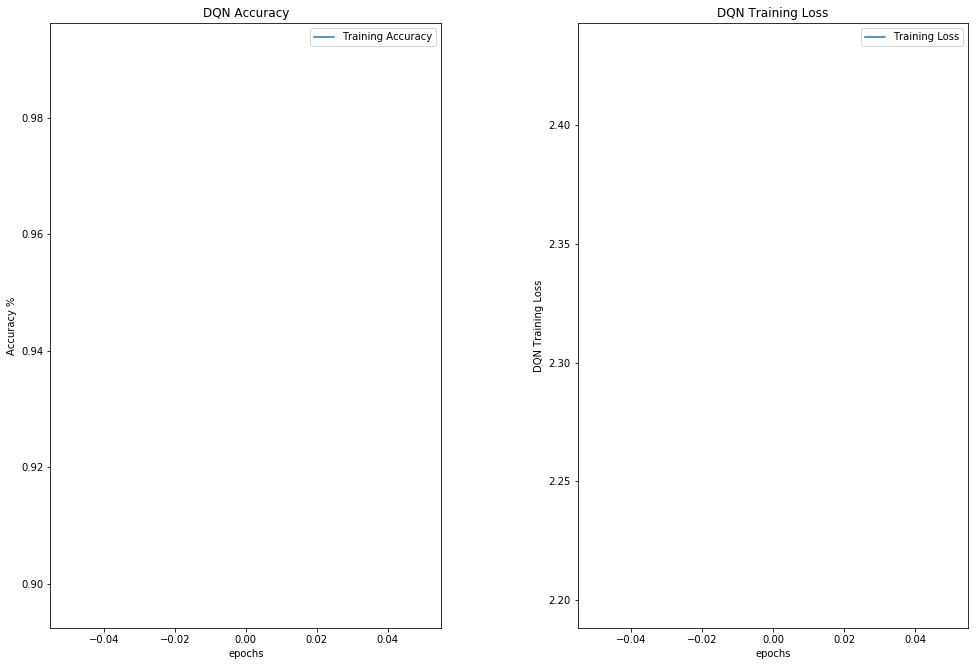

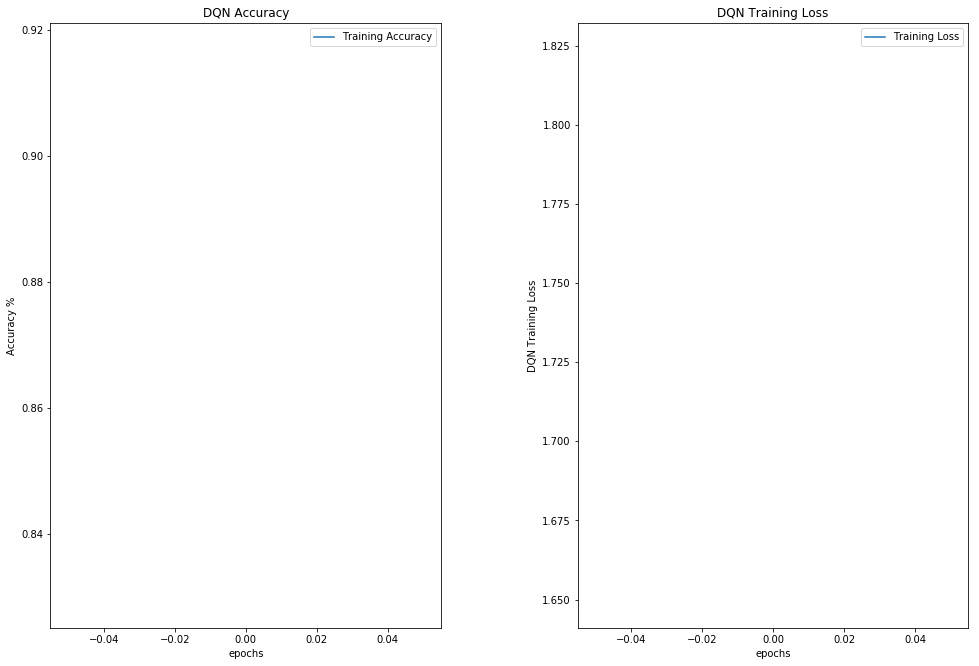

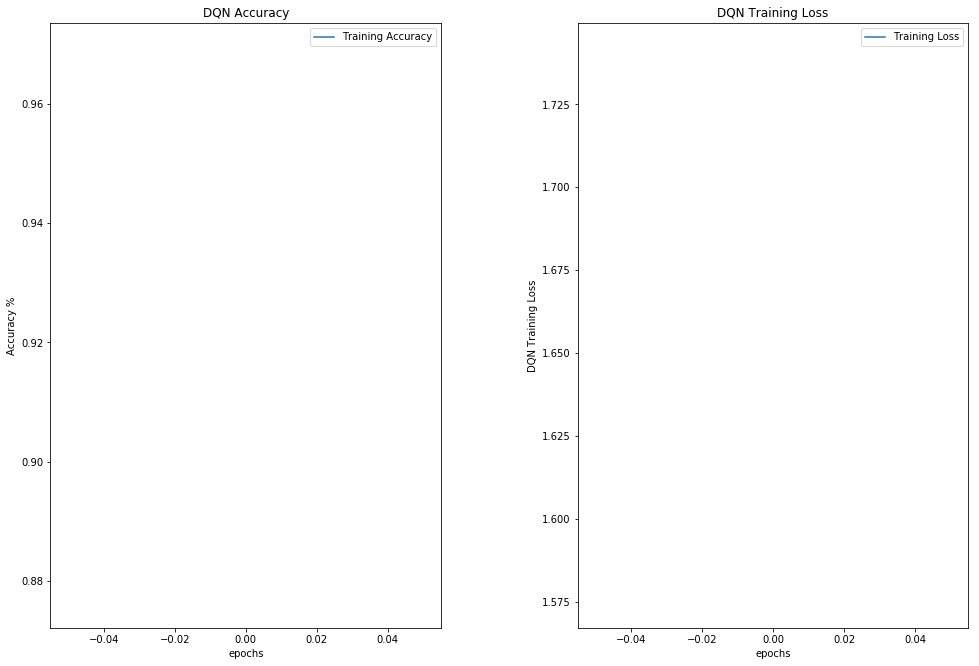

In [13]:
global gameExit
gameExit = False
while not gameExit:
    episode_length += 1
    reward = LIFE_REWARD
    next_state[0] = state[1]

    # Execute game tick and poll for system events
    clock.tick(fps)
    for e in pygame.event.get():
        if e.type == QUIT:
            DQA.quit()
            sys.exit(0)

    # Change direction according to the action
    if action == 0 and direction != "right":
        direction = "left"
        lead_x_change = -snake_speed
        lead_y_change = 0
    elif action == 1 and direction != "left":
        direction = "right"
        lead_x_change = snake_speed
        lead_y_change = 0
    elif action == 2 and direction != "down":
        direction = "up"
        lead_y_change = -snake_speed
        lead_x_change = 0
    elif action == 3 and direction != "up":
        direction = "down"
        lead_y_change = snake_speed
        lead_x_change = 0 
        
    # Eats apple
    if lead_x > randAppleX and lead_x < randAppleX + AppleThickness or lead_x + block_size > randAppleX and lead_x + block_size < randAppleX + AppleThickness:
        if lead_y > randAppleY and lead_y < randAppleY + AppleThickness:
            randAppleX, randAppleY = randAppleGen()
            snakeLength += 1
            reward = APPLE_REWARD
        elif lead_y + block_size > randAppleY and lead_y + block_size < randAppleY + AppleThickness:
            randAppleX, randAppleY = randAppleGen()
            snakeLength += 1
            reward = APPLE_REWARD
            
    # Hits itself
    for eachSegment in snakeList[:-1]:
        if eachSegment == snakeHead:
            must_die = True
            reward = DEATH_REWARD
            
    # Hits walls
    if lead_x >= display_width - block_size or lead_x < 0 or lead_y >= display_height - block_size or lead_y < 0:
        must_die = True
        reward = DEATH_REWARD
        
    # Now move the snake and update the game screen
    lead_x += lead_x_change
    lead_y += lead_y_change

    gameDisplay.fill(white)
    gameDisplay.blit(appleimg, (randAppleX, randAppleY))

    snakeHead = []
    snakeHead.append(lead_x)
    snakeHead.append(lead_y)
    snakeList.append(snakeHead)

    if len(snakeList) > snakeLength:
        del snakeList[0]

    snake(block_size, snakeList)
    Score(snakeLength-1)
    pygame.display.update()
    
    # Update next state
    next_state[1] = screenshot()

    # Add SARS tuple to experience_buffer
    experience_buffer.append((np.asarray([state]), action, reward,
                              np.asarray([next_state]),
                              True if must_die else False))
    episode_reward += reward

    # Change current state
    state = list(next_state)

    # Poll the DQAgent to get the next action
    action = DQA.get_action(np.asarray([state]), testing=must_test)

    # Stopping condition
    if must_die or episode_length > len(snakeList) * MAX_EPISODE_LENGTH_FACTOR: #len(snakeList is experimental)
        die()

# References
[1] [Playing Snake with Deep Q-Learning by Daniele Grattarola](https://github.com/danielegrattarola/deep-q-snake)

[2] [Pygame (Python Game Development)](https://www.youtube.com/playlist?list=PL6gx4Cwl9DGAjkwJocj7vlc_mFU-4wXJq)